<a href="https://colab.research.google.com/github/AdityaJ9801/TRYONDIFFUSION1.0/blob/main/PokemonGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
- generate Pokemon image using gan (Generative Adversial Network)  
- Dataset :  https://www.kaggle.com/datasets/noodulz/pokemon-dataset-1000

# References
- https://arxiv.org/pdf/1511.06434
- https://www.kaggle.com/code/kandelgaurav5/1000-pokemon-dataset-efficientnet
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#generator


Architecture guidelines for stable Deep Convolutional GANs:  
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).  
• Use batchnorm in both the generator and the discriminator.  
• Remove fully connected hidden layers for deeper architectures.  
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.  
• Use LeakyReLU activation in the discriminator for all layers.

In [ ]:
!pip install torchinfo

### Importing Libraries

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

### Importing Dataset from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")
print("Path to dataset files:", path)

100%|██████████| 785M/785M [01:57<00:00, 6.98MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/noodulz/pokemon-dataset-1000/versions/2


In [ ]:
import os
import pandas as pd
dataset_path = "/root/.cache/kagglehub/datasets/noodulz/pokemon-dataset-1000/versions/2"+"/pokemon-dataset-1000"
files = os.listdir(dataset_path)

metadata = pd.read_csv(dataset_path+'/metadata.csv')
print(metadata.info())
metadata.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 entries, 0 to 26538
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            26539 non-null  object
 1   image_path       26539 non-null  object
 2   hp               26539 non-null  int64 
 3   attack           26539 non-null  int64 
 4   defense          26539 non-null  int64 
 5   special-attack   26539 non-null  int64 
 6   special-defense  26539 non-null  int64 
 7   speed            26539 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.6+ MB
None


,label,image_path,hp,attack,defense,special-attack,special-defense,speed
0,abomasnow,dataset/abomasnow/abomasnow_8.png,90,92,75,92,85,60
1,abomasnow,dataset/abomasnow/abomasnow_18.png,90,92,75,92,85,60
2,abomasnow,dataset/abomasnow/abomasnow_11.png,90,92,75,92,85,60
3,abomasnow,dataset/abomasnow/abomasnow_16.png,90,92,75,92,85,60
4,abomasnow,dataset/abomasnow/abomasnow_9.png,90,92,75,92,85,60
5,abomasnow,dataset/abomasnow/abomasnow_7.png,90,92,75,92,85,60
6,abomasnow,dataset/abomasnow/abomasnow_40.png,90,92,75,92,85,60
7,abomasnow,dataset/abomasnow/abomasnow_35.png,90,92,75,92,85,60
8,abomasnow,dataset/abomasnow/abomasnow_32.png,90,92,75,92,85,60
9,abomasnow,dataset/abomasnow/abomasnow_4.png,90,92,75,92,85,60


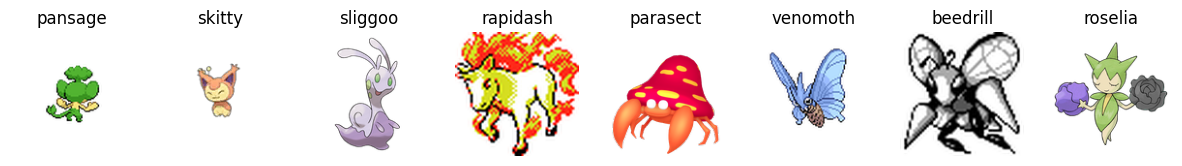

In [ ]:
def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img_path in zip(axes, images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(os.path.dirname(img_path)))
    plt.show()

def get_random_images(folder_path, num_images):
    images = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            category_images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
            if category_images:
                images.append(random.choice(category_images))
    return images[:num_images]

num_images = 8
random_images = get_random_images(dataset_path+'/dataset', num_images)
display_images(random_images)


Class names: ['dataset', 'test', 'train', 'val']
Class to index mapping: {'dataset': 0, 'test': 1, 'train': 2, 'val': 3}
Batch size: 32, Image shape: torch.Size([32, 3, 128, 128]), Labels: tensor([2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0,
        0, 0, 2, 2, 2, 2, 2, 0])


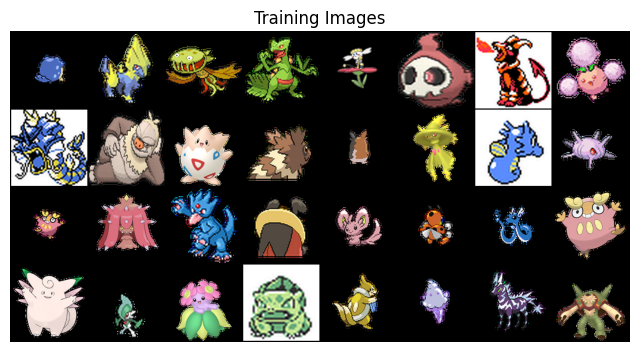

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataroot = dataset_path
image_size = 128
batch_size = 32
workers = 2 # Data loading happens in separate worker processes that load batches in parallel and push them into the queue for faster access by the GPU or CPU.
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),# Convert images to tensor
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                      shuffle=True, num_workers=workers)
# Check class labels
print(f"Class names: {dataset.classes}")
print(f"Class to index mapping: {dataset.class_to_idx}")

# Iterate over the DataLoader
for images, labels in dataloader:
    print(f"Batch size: {images.size(0)}, Image shape: {images.shape}, Labels: {labels}")
    break

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
#@title Dimension of image
import cv2
image_path = dataset_path + "/dataset/abomasnow/abomasnow_11.png"
image = cv2.imread(image_path)
height, width, channels = image.shape

print(f"Image size: {width}x{height}, Channels: {channels}")

Image size: 128x128, Channels: 3


Dataset has images of shape (3,128,128)

In [ ]:
#@title Inputs
'''
n_epochs: the number of times you iterate through the entire dataset when training
z_dim: the dimension of the noise vector
batch_size: the number of images per forward/backward pass
lr: the learning rate
beta_1, beta_2: the momentum term
device: the device type
'''

z_dim = 256
n_epochs = 2

batch_size = 32
lr = 0.0002
# hyperparameter for Adam optimizers
beta_1 = 0.5
beta_2 = 0.999

### Generator Model

In [ ]:
class Generator(nn.Module):
  '''
  Generator class
    Values:
      z_dim : dimension of noise vector , scalar
      hidden_dim : inner dimension
      in_dim : number of channels in images, fitted for dataset used , saclar
  '''
  def __init__(self,z_dim=256,hidden_dim=64,in_dim=3):
    super(Generator,self).__init__()
    self.z_dim = z_dim

    #Build the neural network
    self.gen = nn.Sequential(
        self.gen_block(z_dim,hidden_dim*16,stride = 1,padding = 0),
        self.gen_block(hidden_dim*16,hidden_dim*8),
        self.gen_block(hidden_dim*8,hidden_dim*4),
        self.gen_block(hidden_dim*4,hidden_dim*2),
        self.gen_block(hidden_dim*2,hidden_dim),
        self.gen_block(hidden_dim,in_dim,final_layer = True )
    )
    # Using kernel_size=4 instead of 3 or 5 helps minimize the checkerboard artifacts that appear in GANs
    # Each ConvTranspose2d layer doubles the spatial size (except the first one), while reducing the number of channels.

  def gen_block(self,input_channel,output_channel,kernel_size = 4,stride = 2,padding=1, final_layer = False):
      '''
      Function to return sequence of operation corresponding to generation block (DCGAN)
      Parameter :
        input_channel: channels input representation has (pixel image that is 128x128X3)
        output_channel: channels output representation should have
        kernel : size ofconvolutional filter (kernel x kernel) , scalar
        stride : stride of covolution , scalar
        final_layer : layer is final or not , boolean
      '''
      if(final_layer == False):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channel,output_channel,kernel_size = kernel_size,stride = stride,padding=padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )
      else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channel,output_channel,kernel_size = kernel_size,stride = stride,padding=padding),
            nn.Tanh()
        )
  def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        To reshape the 2D noise vector (batch_size, z_dim) into a 4D tensor with width and height = 1×1,
        This ensures the noise can properly pass through the first ConvTranspose2d layer

        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)

        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self,noise):
    '''
    Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    x = self.unsqueeze_noise(noise)
    return self.gen(x)


def get_noise(n_samples,z_dim,device='cpu'):
  '''
  Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
  creates a tensor of that shape filled with random numbers from the normal distribution.
  Parameter :
    n_samples: number of sample to generate , scalas
    z_dim: dimension of noise vector, scalar
    device: device to load tensor on
  '''
  return torch.randn(n_samples,z_dim,device = device)

In [ ]:
#@title Generator Summary
G = Generator(100,64,3)
summary(G, input_size=(1, 1, 10,10 ))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 128, 128]          --
├─Sequential: 1-1                        [1, 3, 128, 128]          --
│    └─Sequential: 2-1                   [1, 1024, 4, 4]           --
│    │    └─ConvTranspose2d: 3-1         [1, 1024, 4, 4]           1,639,424
│    │    └─BatchNorm2d: 3-2             [1, 1024, 4, 4]           2,048
│    │    └─ReLU: 3-3                    [1, 1024, 4, 4]           --
│    └─Sequential: 2-2                   [1, 512, 8, 8]            --
│    │    └─ConvTranspose2d: 3-4         [1, 512, 8, 8]            8,389,120
│    │    └─BatchNorm2d: 3-5             [1, 512, 8, 8]            1,024
│    │    └─ReLU: 3-6                    [1, 512, 8, 8]            --
│    └─Sequential: 2-3                   [1, 256, 16, 16]          --
│    │    └─ConvTranspose2d: 3-7         [1, 256, 16, 16]          2,097,408
│    │    └─BatchNorm2d: 3-8             [1, 256, 16, 16] 

### Discriminator

In [ ]:
class Discriminator(nn.Module):
  '''
  Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
  '''
  def __init__(self,im_chan=3,hidden_dim=64):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
            self.disc_block(im_chan, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, 1, final_layer=True),
        )

  def disc_block(self,input_channel,output_channel,kernel_size=4,stride=2,final_layer=False):
       '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
       if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
       else :
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride)
            )

  def forward(self,image):
      '''
      Function for completing a forward pass of the discriminator: Given an image tensor,
      returns a 1-dimension tensor representing fake/real.
      Parameters:
         image: a flattened image tensor with dimension (im_dim)
      '''
      disc_pred = self.disc(image)
      return disc_pred.view(len(disc_pred), -1)

In [ ]:
#@title Discriminator Summary
D = Discriminator(3,64)
summary(D,input_size=[1,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 196]                  --
├─Sequential: 1-1                        [1, 1, 14, 14]            --
│    └─Sequential: 2-1                   [1, 64, 63, 63]           --
│    │    └─Conv2d: 3-1                  [1, 64, 63, 63]           3,136
│    │    └─BatchNorm2d: 3-2             [1, 64, 63, 63]           128
│    │    └─LeakyReLU: 3-3               [1, 64, 63, 63]           --
│    └─Sequential: 2-2                   [1, 128, 30, 30]          --
│    │    └─Conv2d: 3-4                  [1, 128, 30, 30]          131,200
│    │    └─BatchNorm2d: 3-5             [1, 128, 30, 30]          256
│    │    └─LeakyReLU: 3-6               [1, 128, 30, 30]          --
│    └─Sequential: 2-3                   [1, 1, 14, 14]            --
│    │    └─Conv2d: 3-7                  [1, 1, 14, 14]            2,049
Total params: 136,769
Trainable params: 136,769
Non-trainable params: 0


Reference Guide :
- https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5
- https://github.com/soumith/ganhacks

 initialize your generator, discriminator, criterion and optimizers.

In [ ]:
'''
criterion: the loss function
'''
criterion = nn.BCEWithLogitsLoss()
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.03
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
#@title Training
cur_step = 0
display_step = 1 # display_step: how often to display/visualize the images
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
        real = real.to(device)
        cur_batch_size = len(real)
        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the discriminator loss
        D_losses.append(disc_loss.item())
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        # Keep track of the generator loss
        G_losses.append(gen_loss.item())

        gen_loss.backward()
        gen_opt.step()

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {gen_loss.item()}, discriminator loss: {disc_loss.item()}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [ ]:
torch.save(gen, "generator.pth")
torch.save(disc, "discriminator.pth")

print("Models saved successfully!")